In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import leastsq

In [3]:
from exoabc.sim import DR24CompletenessModel

In [4]:
inj = pd.read_csv("data/q1_q17_dr24/injections.csv")
robo = pd.read_csv("data/q1_q17_dr24/robovetter.csv")

In [70]:
joined = pd.merge(inj, robo, left_on=("kepid", "period"), right_on=("KIC", "injPer"), how="left")
print(len(inj), len(joined), np.sum((joined.recovered==1) & joined.KIC.isnull()))
joined = pd.DataFrame(joined[(joined.offset_from_source == 0)
                             & (joined.expect_mes > 1.0)
                             & (joined.expect_mes < 30.0)
                             & (joined.period > 1.0)
                             & (joined.period < 500.0)])

159013 159013 0


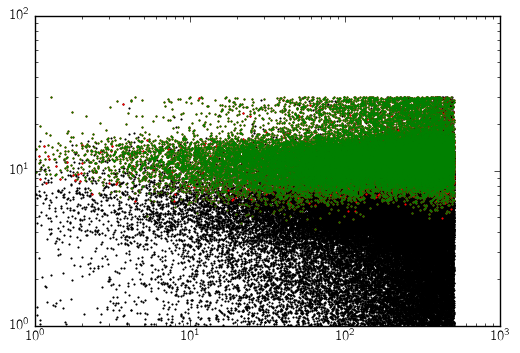

In [71]:
x = np.array(joined.period)
y = np.array(joined.expect_mes)
m_rec = np.array(joined.recovered == 1)
m_robo = np.array(joined.Disp == "PC")
m_all = m_rec & m_robo
z = 1.0 * m_all

plt.loglog(x[~m_all], y[~m_all], ".k", ms=2)
plt.loglog(x[m_rec], y[m_rec], ".r", ms=2)
plt.loglog(x[m_robo], y[m_robo], ".g", ms=2)

In [72]:
# Compute the weights (prior) model.
N_all, X, Y = np.histogram2d(np.log(x), np.log(y), (12, 13))
inds_x = np.clip(np.digitize(np.log(x), X) - 1, 0, len(X) - 2)
inds_y = np.clip(np.digitize(np.log(y), Y) - 1, 0, len(Y) - 2)
w = np.sqrt(N_all[inds_x, inds_y])

N_rec, X, Y = np.histogram2d(np.log(x[m_all]), np.log(y[m_all]), (X, Y))

frac = N_rec / N_all
frac[np.isnan(frac)] = 0.0

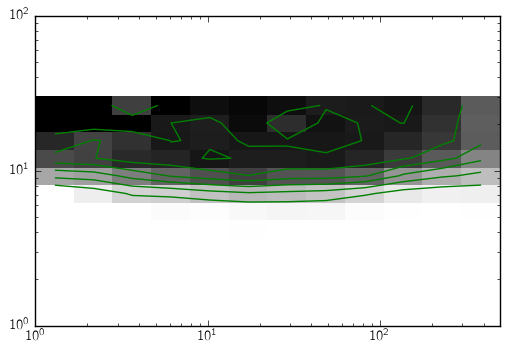

In [73]:
plt.pcolor(np.exp(X), np.exp(Y), frac.T, cmap="gray_r")
plt.contour(np.exp(0.5*(X[:-1]+X[1:])), np.exp(0.5*(Y[:-1]+Y[1:])), frac.T, colors="g")
plt.xscale("log")
plt.yscale("log")
plt.ylim(1.0, 100);

In [74]:
def model(p, mes):
    y = p[0] / (1.0 + np.exp(-(mes - p[1]) * np.exp(-p[2])))
    return y * (y <= 1.0) * (y > 0.0) + 1.0 * (y > 1.0)

In [92]:
colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
    "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
]

15273 10 70 [ 0.91085329  8.09058703 -0.14945637]
14022 70 130 [ 0.90113881  8.73098084 -0.04260804]
13460 130 190 [ 0.86669866  9.66385986  0.0521611 ]
13415 190 250 [ 0.82811217  9.88228404  0.15222962]
12698 250 310 [  0.78854683  10.1166518    0.2806315 ]


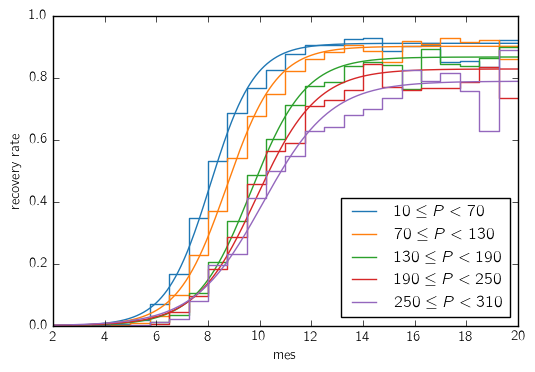

In [116]:
fig = plt.figure()
ax = fig.add_subplot(111)
bins = np.linspace(2, 20, 25)
y2 = np.linspace(2, 20, 1000)

period_bins = np.arange(10, 311, 60)
for i, c in enumerate(colors[:len(period_bins)-1]):
    a, b = period_bins[i:i+2]
    m = (a <= x) & (x < b)
    resid = lambda p: (z[m] - model(p, y[m])) / w[m]
    p0 = np.array([0.7, 0.5, 10.0])
    params, _, info, msg, flag = leastsq(resid, p0, full_output=True)
    
    n_tot, _ = np.histogram(y[m], bins)
    n_rec, _ = np.histogram(y[m][z[m] > 0], bins)
    n = n_rec / n_tot
    ax.step(bins[1:], n, color=c)
#     ax.errorbar(0.5*(bins[:-1] + bins[1:]), n, yerr=n / np.sqrt(n_rec), fmt=".",
#                 color=c, capsize=0)
    ax.plot(y2, model(params, y2), color=c, label="${0:.0f} \le P < {1:.0f}$".format(a, b))

    print(m.sum(), a, b, params)
ax.set_xlabel("mes")
ax.set_ylabel("recovery rate")
ax.legend(loc=4, fontsize=12)

In [76]:
# Fit the completeness model.
p0 = np.array([0.0, 0.0, 0.7, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0])
completeness_model = DR24CompletenessModel()
resid = lambda p: (z - completeness_model.get_pdet(p, x, y)) / w
params, _, info, msg, flag = leastsq(resid, p0, full_output=True)

In [77]:
params

array([ -0.01173482,   0.04514176,   0.89043295,   0.32419671,
        -2.0032159 ,  11.0954351 ,   0.07065627,  -0.44128716,   0.50679618])

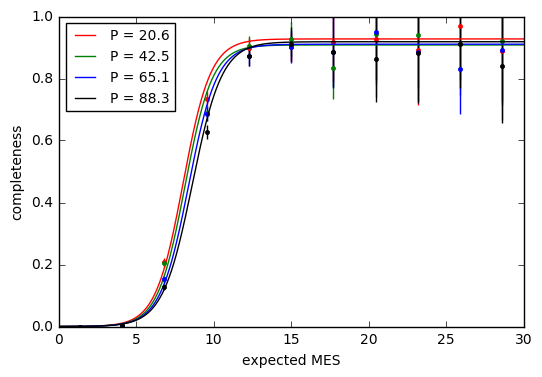

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111)
q = np.exp(np.percentile(np.log(x), [25, 50, 75]))
b = np.linspace(0, 30, 12)
y2 = np.linspace(0, 30, 1000)
for mn, mx, c in zip(np.append(x.min(), q), np.append(q, x.max()), "rgbk"):
    m = (mn <= x) & (x < mx)
    n_tot, _ = np.histogram(y[m], b)
    n_rec, _ = np.histogram(y[m][z[m] > 0], b)
    n = n_rec / n_tot
    ax.errorbar(0.5*(b[:-1] + b[1:]), n, yerr=n / np.sqrt(n_rec), fmt=".",
                color=c, capsize=0)
    z2 = completeness_model.get_pdet(params, 0.5*(mn+mx)+np.zeros_like(y2),
                                     y2)
    ax.plot(y2, z2, color=c, label="P = {0:.1f}".format(0.5*(mn+mx)))
# ax.set_xlim(0, 3*mesthresh)
ax.set_xlabel("expected MES")
ax.set_ylabel("completeness")
ax.legend(loc=2, fontsize=10);